In [1]:
#Import libraries
#Tensorflow would be use for the nn of GAN this time
import numpy as np
import os 
import matplotlib.pyplot as plt
import cv2

import warnings
warnings.filterwarnings('ignore')

import keras
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, Reshape, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Conv2DTranspose

from tensorflow.compat.v1.keras.layers import BatchNormalization

In [2]:
#This is from the library of the os
#Sortimg out the data (images)
def list_images(basePath, contains=None):

    return list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp"), contains=contains)

In [3]:
#Still part of the data sorting process
def list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp"), contains=None):

    for (rootDir, dirNames, filenames) in os.walk(basePath):

        for filename in filenames:

            if contains is not None and filename.find(contains) == -1:
                continue


            ext = filename[filename.rfind("."):].lower()


            if ext.endswith(validExts):

                imagePath = os.path.join(rootDir, filename).replace(" ", "\\ ")
                yield imagePath

In [4]:
def load_images(directory='', size=(64,64)):
    images = []
    labels = [] 
    label = 0
    
    imagePaths = list(list_images(directory))
    
    for path in imagePaths:
        
        if not('OSX' in path):
        
            path = path.replace('\\','/')

            image = cv2.imread(path) 
            image = cv2.resize(image,size) 

            images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    return images

In [5]:
#Connect personal drive to colab for data to be imported to the program
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#The zip file is downloaded as opposed to the huge amount of photo
#Unzip the file to extraxt conetent temporarily 
!unzip /content/drive/MyDrive/GAN/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/62764_2019.jpg   
  inflating: images/62765_2019.jpg   
  inflating: images/62766_2019.jpg   
  inflating: images/62767_2019.jpg   
  inflating: images/62768_2019.jpg   
  inflating: images/62769_2019.jpg   
  inflating: images/6276_2003.jpg    
  inflating: images/62770_2019.jpg   
  inflating: images/62771_2019.jpg   
  inflating: images/62772_2019.jpg   
  inflating: images/62773_2019.jpg   
  inflating: images/62774_2019.jpg   
  inflating: images/62775_2019.jpg   
  inflating: images/62776_2019.jpg   
  inflating: images/62777_2019.jpg   
  inflating: images/62778_2019.jpg   
  inflating: images/62779_2019.jpg   
  inflating: images/6277_2003.jpg    
  inflating: images/62780_2019.jpg   
  inflating: images/62781_2019.jpg   
  inflating: images/62782_2019.jpg   
  inflating: images/62783_2019.jpg   
  inflating: images/62784_2019.jpg   
  inflating: images/62785_2019.jpg   
  inflating: images/62786_2019.jpg   

In [7]:
#Import dataset
images=load_images('/content/images')

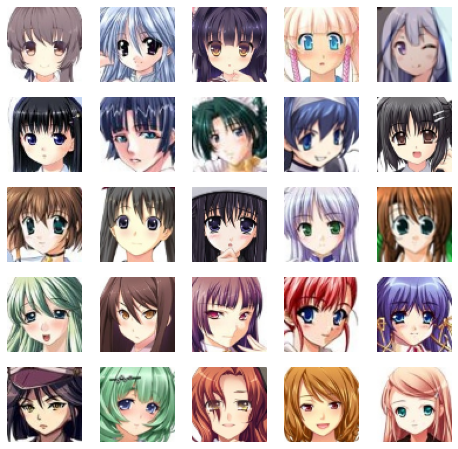

In [8]:
#Show images
_,ax = plt.subplots(5,5, figsize = (8,8)) 
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(images[5*i+j])
        ax[i,j].axis('off')

In [9]:
#This is where parameters of gan are defined
class GAN():
    def __init__(self):
        self.img_shape = (64, 64, 3)
        
        self.noise_size = 100

        optimizer = Adam(0.0002,0.5)

        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', 
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        self.combined = Sequential()
        self.combined.add(self.generator)
        self.combined.add(self.discriminator)
        
        self.discriminator.trainable = False
        
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        self.combined.summary()
        
#Building the generator, layers allows development complex structure
    def build_generator(self):
        epsilon = 0.00001 
        noise_shape = (self.noise_size,)
        
        model = Sequential()
        
        model.add(Dense(4*4*512, activation='linear', input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Reshape((4, 4, 512)))
        
        model.add(Conv2DTranspose(512, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(256, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(128, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(64, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(3, kernel_size=[4,4], strides=[1,1], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))

       
        model.add(Activation("tanh"))
        
        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

#Determines real images fake 
    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(128, (3,3), padding='same', input_shape=self.img_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(3,3)))
        model.add(Dropout(0.2))

        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(3,3)))
        model.add(Dropout(0.3))

        model.add(Flatten())
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        
        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

#Data training parameters
    def train(self, epochs, batch_size=128, metrics_update=50, save_images=100, save_model=2000):

        X_train = np.array(images)
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5

        half_batch = int(batch_size / 2)
        
        mean_d_loss=[0,0]
        mean_g_loss=0

        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, self.noise_size))
            gen_imgs = self.generator.predict(noise)

           
            
           
            d_loss = 0.5 * np.add(self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1))),
                                  self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1))))

            
            for _ in range(2):
                noise = np.random.normal(0, 1, (batch_size, self.noise_size))

                valid_y = np.array([1] * batch_size)
                g_loss = self.combined.train_on_batch(noise, valid_y)
            
            mean_d_loss[0] += d_loss[0]
            mean_d_loss[1] += d_loss[1]
            mean_g_loss += g_loss
            
            
            
            if epoch % metrics_update == 0:
                print ("%d [Discriminator loss: %f, acc.: %.2f%%] [Generator loss: %f]" % (epoch, mean_d_loss[0]/metrics_update, 100*mean_d_loss[1]/metrics_update, mean_g_loss/metrics_update))
                mean_d_loss=[0,0]
                mean_g_loss=0
            
            
            if epoch % save_images == 0:
                self.save_images(epoch)
            
           
            
            if epoch % save_model == 0:
                self.generator.save("generator_%d" % epoch)
                self.discriminator.save("discriminator_%d" % epoch)


#25 images are saved and generated with this 
    def save_images(self, epoch):
        noise = np.random.normal(0, 1, (25, self.noise_size))
        gen_imgs = self.generator.predict(noise)
        
        
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(5,5, figsize = (8,8))

        for i in range(5):
            for j in range(5):
                axs[i,j].imshow(gen_imgs[5*i+j])
                axs[i,j].axis('off')

        plt.show()
        
        fig.savefig("animeGenerated/Faces_%d.png" % epoch)
        plt.close()

In [10]:
#Images generated through training
!mkdir animeGenerated

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 128)       0         
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 128)      512       
 hNormalization)                                        

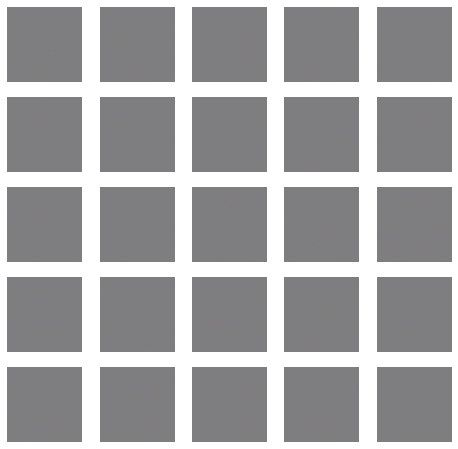

4/4 [==============================] - 0s 21ms/step
200 [Discriminator loss: 0.661690, acc.: 61.91%] [Generator loss: 1.303158]
4/4 [==============================] - 0s 19ms/step
400 [Discriminator loss: 0.705373, acc.: 52.95%] [Generator loss: 1.010435]
4/4 [==============================] - 0s 18ms/step
600 [Discriminator loss: 0.690313, acc.: 54.27%] [Generator loss: 0.994956]
4/4 [==============================] - 0s 19ms/step
800 [Discriminator loss: 0.657564, acc.: 60.26%] [Generator loss: 1.184100]
4/4 [==============================] - 0s 19ms/step
1000 [Discriminator loss: 0.657667, acc.: 60.33%] [Generator loss: 1.258837]
1/1 [==============================] - 0s 17ms/step


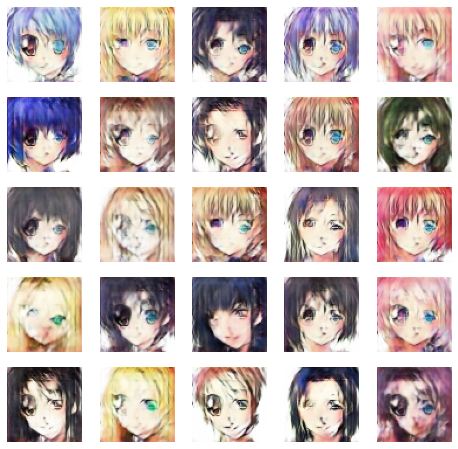

4/4 [==============================] - 0s 19ms/step
1200 [Discriminator loss: 0.667611, acc.: 59.17%] [Generator loss: 1.170589]
4/4 [==============================] - 0s 19ms/step
1400 [Discriminator loss: 0.661207, acc.: 59.80%] [Generator loss: 1.180743]
4/4 [==============================] - 0s 18ms/step
1600 [Discriminator loss: 0.658586, acc.: 60.41%] [Generator loss: 1.198018]
4/4 [==============================] - 0s 19ms/step
1800 [Discriminator loss: 0.662687, acc.: 59.83%] [Generator loss: 1.187391]
4/4 [==============================] - 0s 19ms/step
2000 [Discriminator loss: 0.647228, acc.: 62.10%] [Generator loss: 1.273528]
1/1 [==============================] - 0s 19ms/step


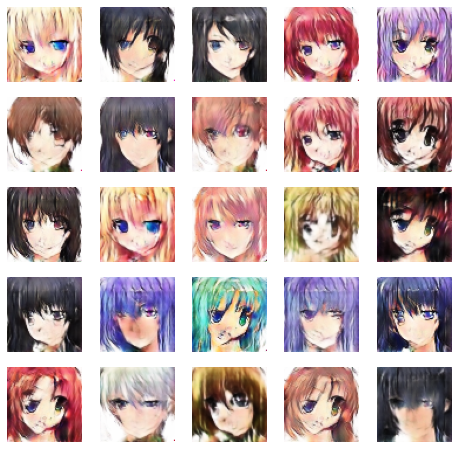

4/4 [==============================] - 0s 19ms/step
2200 [Discriminator loss: 0.637584, acc.: 62.90%] [Generator loss: 1.328165]
4/4 [==============================] - 0s 19ms/step
2400 [Discriminator loss: 0.627008, acc.: 64.47%] [Generator loss: 1.402103]
4/4 [==============================] - 0s 20ms/step
2600 [Discriminator loss: 0.620343, acc.: 65.08%] [Generator loss: 1.444770]
4/4 [==============================] - 0s 20ms/step
2800 [Discriminator loss: 0.607314, acc.: 66.40%] [Generator loss: 1.506401]
4/4 [==============================] - 0s 19ms/step
3000 [Discriminator loss: 0.605241, acc.: 66.67%] [Generator loss: 1.519863]
1/1 [==============================] - 0s 15ms/step


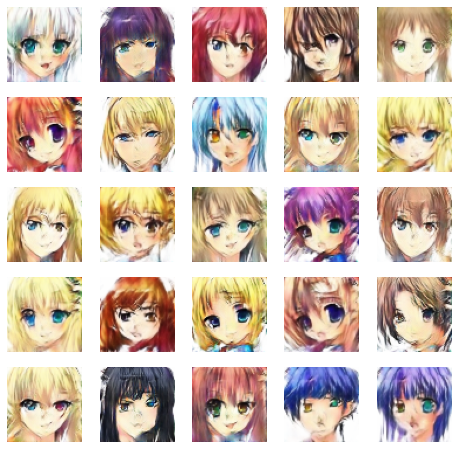

4/4 [==============================] - 0s 19ms/step
3200 [Discriminator loss: 0.590635, acc.: 68.11%] [Generator loss: 1.598783]
4/4 [==============================] - 0s 18ms/step
3400 [Discriminator loss: 0.584229, acc.: 68.40%] [Generator loss: 1.613363]
4/4 [==============================] - 0s 20ms/step
3600 [Discriminator loss: 0.565085, acc.: 69.98%] [Generator loss: 1.712452]
4/4 [==============================] - 0s 19ms/step
3800 [Discriminator loss: 0.573282, acc.: 69.42%] [Generator loss: 1.703851]
4/4 [==============================] - 0s 19ms/step
4000 [Discriminator loss: 0.582441, acc.: 68.59%] [Generator loss: 1.671962]
1/1 [==============================] - 0s 16ms/step


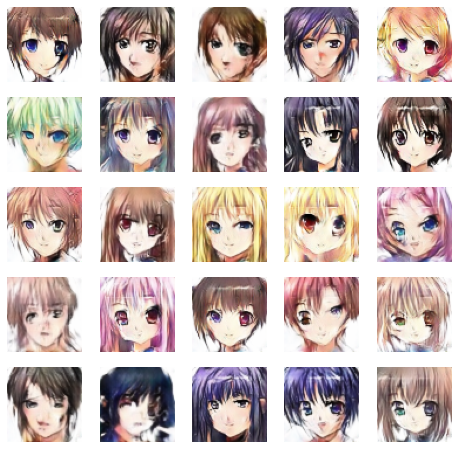

4/4 [==============================] - 0s 18ms/step
4200 [Discriminator loss: 0.546605, acc.: 71.68%] [Generator loss: 1.805936]
4/4 [==============================] - 0s 18ms/step
4400 [Discriminator loss: 0.551429, acc.: 71.00%] [Generator loss: 1.893322]
4/4 [==============================] - 0s 19ms/step
4600 [Discriminator loss: 0.549801, acc.: 71.48%] [Generator loss: 1.868877]
4/4 [==============================] - 0s 19ms/step
4800 [Discriminator loss: 0.539514, acc.: 72.32%] [Generator loss: 1.901985]
4/4 [==============================] - 0s 19ms/step
5000 [Discriminator loss: 0.535509, acc.: 72.59%] [Generator loss: 1.977224]
1/1 [==============================] - 0s 18ms/step


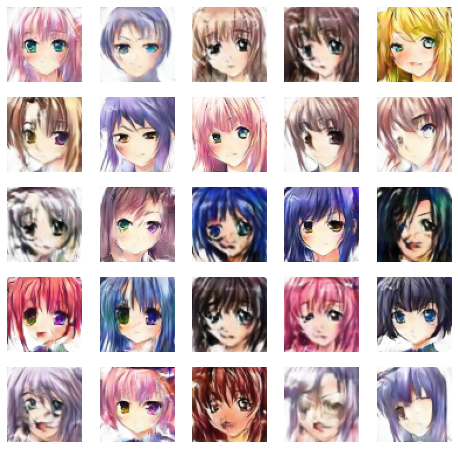

4/4 [==============================] - 0s 21ms/step
5200 [Discriminator loss: 0.539134, acc.: 72.18%] [Generator loss: 1.923753]
4/4 [==============================] - 0s 19ms/step
5400 [Discriminator loss: 0.531148, acc.: 73.03%] [Generator loss: 1.953191]
4/4 [==============================] - 0s 19ms/step
5600 [Discriminator loss: 0.507144, acc.: 74.84%] [Generator loss: 2.145438]
4/4 [==============================] - 0s 18ms/step
5800 [Discriminator loss: 0.513698, acc.: 74.16%] [Generator loss: 2.096296]
4/4 [==============================] - 0s 20ms/step
6000 [Discriminator loss: 0.515129, acc.: 74.11%] [Generator loss: 2.072587]
1/1 [==============================] - 0s 16ms/step


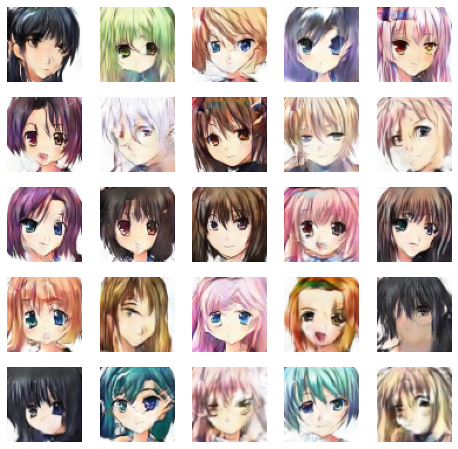

4/4 [==============================] - 0s 18ms/step
6200 [Discriminator loss: 0.498977, acc.: 75.35%] [Generator loss: 2.181359]
4/4 [==============================] - 0s 19ms/step
6400 [Discriminator loss: 0.492575, acc.: 75.56%] [Generator loss: 2.247157]
4/4 [==============================] - 0s 19ms/step
6600 [Discriminator loss: 0.483008, acc.: 76.57%] [Generator loss: 2.278089]
4/4 [==============================] - 0s 19ms/step
6800 [Discriminator loss: 0.482830, acc.: 76.53%] [Generator loss: 2.318532]
4/4 [==============================] - 0s 20ms/step
7000 [Discriminator loss: 0.487361, acc.: 76.09%] [Generator loss: 2.320665]
1/1 [==============================] - 0s 17ms/step


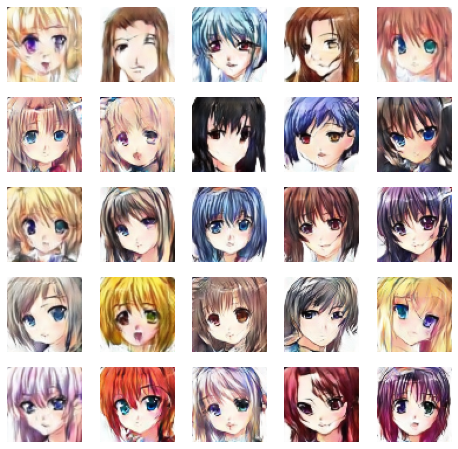

4/4 [==============================] - 0s 19ms/step
7200 [Discriminator loss: 0.472780, acc.: 76.78%] [Generator loss: 2.372032]
4/4 [==============================] - 0s 18ms/step
7400 [Discriminator loss: 0.477413, acc.: 76.76%] [Generator loss: 2.395871]
4/4 [==============================] - 0s 18ms/step
7600 [Discriminator loss: 0.451545, acc.: 78.44%] [Generator loss: 2.497906]
4/4 [==============================] - 0s 20ms/step
7800 [Discriminator loss: 0.460637, acc.: 77.86%] [Generator loss: 2.529914]
4/4 [==============================] - 0s 20ms/step
8000 [Discriminator loss: 0.442852, acc.: 79.05%] [Generator loss: 2.614890]
1/1 [==============================] - 0s 21ms/step


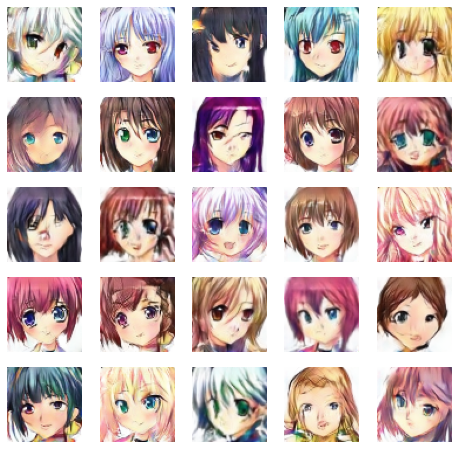

4/4 [==============================] - 0s 19ms/step
8200 [Discriminator loss: 0.434195, acc.: 79.48%] [Generator loss: 2.734105]
4/4 [==============================] - 0s 19ms/step
8400 [Discriminator loss: 0.445050, acc.: 78.71%] [Generator loss: 2.696241]
4/4 [==============================] - 0s 18ms/step
8600 [Discriminator loss: 0.439110, acc.: 79.40%] [Generator loss: 2.698958]
4/4 [==============================] - 0s 20ms/step
8800 [Discriminator loss: 0.430754, acc.: 79.72%] [Generator loss: 2.748266]
4/4 [==============================] - 0s 20ms/step
9000 [Discriminator loss: 0.368590, acc.: 83.12%] [Generator loss: 3.121965]
1/1 [==============================] - 0s 15ms/step


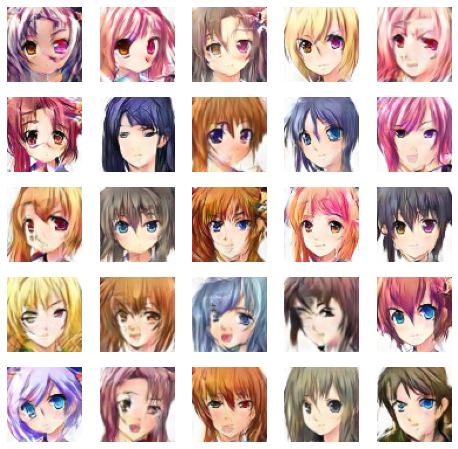

4/4 [==============================] - 0s 20ms/step
9200 [Discriminator loss: 0.409848, acc.: 81.13%] [Generator loss: 2.912766]
4/4 [==============================] - 0s 20ms/step
9400 [Discriminator loss: 0.417416, acc.: 80.56%] [Generator loss: 2.830421]
4/4 [==============================] - 0s 19ms/step
9600 [Discriminator loss: 0.428184, acc.: 80.14%] [Generator loss: 2.815119]
4/4 [==============================] - 0s 20ms/step
9800 [Discriminator loss: 0.420320, acc.: 80.27%] [Generator loss: 2.840870]
4/4 [==============================] - 0s 21ms/step
10000 [Discriminator loss: 0.397842, acc.: 81.55%] [Generator loss: 3.033636]
1/1 [==============================] - 0s 15ms/step


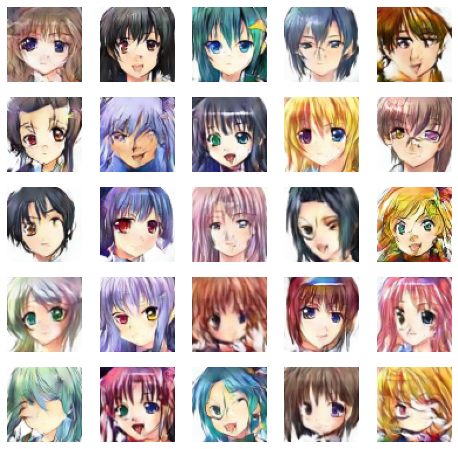

4/4 [==============================] - 0s 23ms/step
10200 [Discriminator loss: 0.398468, acc.: 81.85%] [Generator loss: 2.980999]
4/4 [==============================] - 0s 21ms/step
10400 [Discriminator loss: 0.394893, acc.: 81.86%] [Generator loss: 3.122762]
4/4 [==============================] - 0s 20ms/step
10600 [Discriminator loss: 0.399500, acc.: 81.63%] [Generator loss: 3.011435]
4/4 [==============================] - 0s 19ms/step
10800 [Discriminator loss: 0.377082, acc.: 83.09%] [Generator loss: 3.073609]
4/4 [==============================] - 0s 21ms/step
11000 [Discriminator loss: 0.374931, acc.: 83.19%] [Generator loss: 3.160044]
1/1 [==============================] - 0s 27ms/step


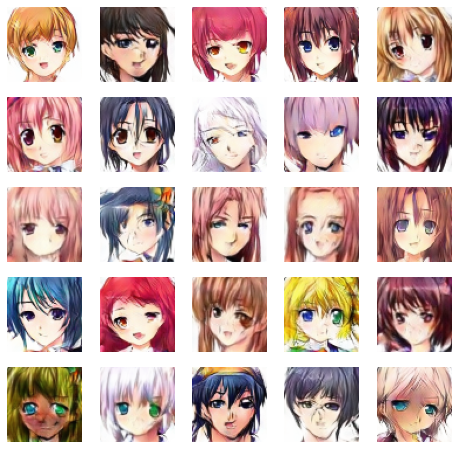

4/4 [==============================] - 0s 19ms/step
11200 [Discriminator loss: 0.387626, acc.: 82.39%] [Generator loss: 3.225733]
4/4 [==============================] - 0s 20ms/step
11400 [Discriminator loss: 0.376200, acc.: 82.91%] [Generator loss: 3.240259]
4/4 [==============================] - 0s 21ms/step
11600 [Discriminator loss: 0.365259, acc.: 83.59%] [Generator loss: 3.279722]
4/4 [==============================] - 0s 21ms/step
11800 [Discriminator loss: 0.363749, acc.: 83.83%] [Generator loss: 3.312723]
4/4 [==============================] - 0s 21ms/step
12000 [Discriminator loss: 0.363326, acc.: 83.67%] [Generator loss: 3.397985]
1/1 [==============================] - 0s 16ms/step


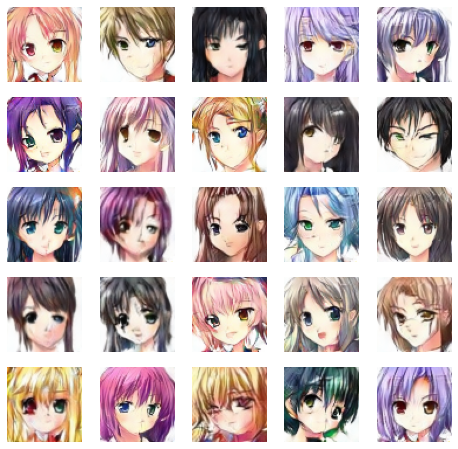

4/4 [==============================] - 0s 21ms/step
12200 [Discriminator loss: 0.357756, acc.: 83.96%] [Generator loss: 3.388647]
4/4 [==============================] - 0s 21ms/step
12400 [Discriminator loss: 0.374773, acc.: 83.15%] [Generator loss: 3.287220]
4/4 [==============================] - 0s 19ms/step
12600 [Discriminator loss: 0.362599, acc.: 83.83%] [Generator loss: 3.395613]
4/4 [==============================] - 0s 21ms/step
12800 [Discriminator loss: 0.357515, acc.: 84.02%] [Generator loss: 3.434583]
4/4 [==============================] - 0s 20ms/step
13000 [Discriminator loss: 0.208774, acc.: 91.30%] [Generator loss: 4.496378]
1/1 [==============================] - 0s 16ms/step


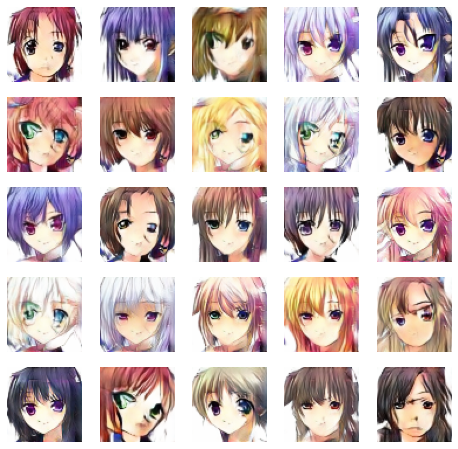

4/4 [==============================] - 0s 20ms/step
13200 [Discriminator loss: 0.259525, acc.: 89.22%] [Generator loss: 4.120249]
4/4 [==============================] - 0s 20ms/step
13400 [Discriminator loss: 0.303652, acc.: 87.00%] [Generator loss: 3.971176]
4/4 [==============================] - 0s 20ms/step
13600 [Discriminator loss: 0.315481, acc.: 86.21%] [Generator loss: 3.818116]
4/4 [==============================] - 0s 20ms/step
13800 [Discriminator loss: 0.324443, acc.: 85.80%] [Generator loss: 3.667934]
4/4 [==============================] - 0s 21ms/step
14000 [Discriminator loss: 0.325229, acc.: 85.96%] [Generator loss: 3.665628]
1/1 [==============================] - 0s 16ms/step


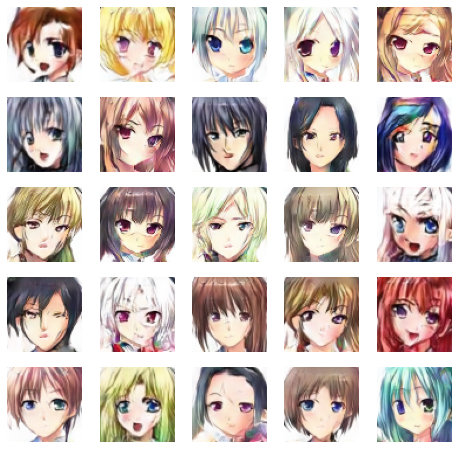

4/4 [==============================] - 0s 22ms/step


In [ ]:
#Training the gan for image generator
gan=GAN()
gan.train(epochs=15000, batch_size=256, metrics_update=200, save_images=1000, save_model=15000)